# Table of Contents
* [1. Introduction](#1.-Introduction)
    * [1.1 Recommendation models](#1.1-Recommendation-models)
    * [1.2 Hybrid Matrix Factorisation Algorithm](#1.2-Hybrid-Matrix-Factorisation-Algorithm)
* [2. Importing Libraries](#2.-Import-Libraries)
   * [2.1 Import external libs](#2.1-Import-external-libs)
   * [2.2 Import internal libs](#2.2-Import-internal-libs)
* [3. Define constant variables](#3.-Define-constant-variables)  
* [4. Product recommendation with Explicit Feedback](#4.-Product-recommendation-with-Explicit-Feedback)
    * [4.1 Import Data & Exploratory Data Analysis](#4.1-Import-Data-&-Exploratory-Data-Analysis)
        * [4.1.1 Deal with duplicates events](#4.1.1-Deal-with-duplicates-events)
        * [4.1.2 Import meta data for product ID](#4.1.2-Import-meta-data-for-product-ID)
    * [4.2 Data Preprocessing](#4.2-Data-Preprocessing)    
        * [4.2.1 Build Interaction Matrix](#4.2.1-Build-Interaction-Matrix)
        * [4.2.2 Split data to train and test](#4.2.2-Split-data-to-train-and-test)
        * [4.2.3 Build User and item dictionaries](#4.2.3-Build-User-and-item-dictionaries)
    * [4.3 Train Matrix Factorization model](#4.3-Train-Matrix-Factorization-model)
    * [4.4 Model Evaluation](#4.4-Model-Evaluation)
    * [4.5 User recommendations](#4.5-User-recommendations)
    * [4.6 User-item recommendations](#4.6-User-item-recommendations)
    * [4.7 Item-item recommendations](#4.7-Item-item-recommendations)
* [5. Product recommendation with implicit Feedback](#5.-Product-recommendation-with-implicit-Feedback)   
    * [5.1 Exploratory Data Analysis](#5.1-Exploratory-Data-Analysis)
    * [5.2 Data Preprocessing](#5.2-Data-Preprocessing) 
        * [5.2.1 Build Interaction Matrix](#5.2.1-Build-Interaction-Matrix)
        * [5.2.2 Split data to train and test](#5.2.2-Split-data-to-train-and-test)
        * [5.2.3 Build User and item dictionaries](#5.2.3-Build-User-and-item-dictionaries)    
    * [5.3 Train Matrix Factorization model with implicit feedback data](#5.3-Train-Matrix-Factorization-model-with-implicit-feedback-data)
    * [5.4 Model Evaluation](#5.4-Model-Evaluation)
    * [5.5 User recommendations](#5.5-User-recommendations)
    * [5.6 User-item recommendations](#5.6-User-item-recommendations)
    * [5.7 Item-item recommendations](#5.7-Item-item-recommendations)
* [6. Conclusion](#6.-Conclusion)

# 1. Introduction

This notebook introduces the concept of a hybrid matrix factorization based model for recommendation. We illustrate how to build a pure matrix factorization using both explicit and/or implicit feedback data. 

## 1.1 Recommendation models

In general most recommendation models can be divided into three types: 

- Collaborative Filtering: 

> Collaborative filtering is a method of making predictions about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person. 
                                                
- Content-Based Filtering: 

> Uses similarity between items to recommend items similar to what the user likes. These methods utilize the description of an item and a profile of the user’s preferred choices. In this type of approches, model tries to recommend products which are similar to the ones that a user has liked in the past. The idea of content-based filtering is that if you like an item you will also like a ‘similar’ item.


- Hybrid recommender system: 

> Hybrid recommender system is a special type of recommender system that combines both content and collaborative filtering method.  These methods can be used to overcome some of the common problems in recommender systems such as cold-start and the sparsity problem.


The choice between these models is mainly based on the data availability. For example, the collaborative filtering model is very effective when sufficient interactions of user-item have been recorded. On the other hand, the content based models can be effective when the metadata of the users and items are available. The hybrid approches  are common to address the cold-start issues, where there are insufficient historical interactions available. 



## 1.2 Hybrid Matrix Factorisation Algorithm

In general, most hybrid approaches incorporate the feature data or meta data in conjunction with the collaborative information (user-item interaction).

[LightFM](https://arxiv.org/abs/1507.08439) is one of the most effective hybrid recommendation algorithms which deal with both implicit and explicit feedbacks use-cases. In this notebook, as example, we will mainly focus on implementation of the LightFM, however, the most methods introduced here are generic and can be utilized for other models as well. 

The LightFM model represents users and items as linear combinations of their content features’ latent factors. The model learns embedding vectors or latent representations of the users and items. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.


# 2. Import libraries

All the required libraries/packages are given in the `requirements.txt` and can be installed by running on the terminal. Make sure you run this command in the same directory where the requirements.txt file is located. <br> 
`pip install -r requirements.txt` 

One can also install the packages directly from the notebook by running: <br> 
`!pip install -r requirements.txt`

In [1]:
!pip install -r requirements.txt

## 2.1 Import external libs

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from itertools import islice
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

## 2.2 Import internal libs

In [3]:
sys.path.append(os.path.abspath("../"))
from src.data_processing_utilities import (build_interaction_matrix, build_user_dict,
                                           build_item_dict, data_preprocessing_implicit_feedback, 
                                           create_train_test_data)

from src.rec_sys import (fit_model, recommendations_items_for_user,
                         recommendations_users_for_item, embedding_matrix,
                         recommendations_items_for_item)

from src.metric_utilities import model_metrics

# 3. Define constant variables

In [4]:
SEED = 44
TEST_PERCENTAGE = 0.3
sns.set(font_scale=2)
pd.options.display.float_format = '{:,.2f}'.format

# 4. Product recommendation with Explicit Feedback

Typically, we have two type of data for building a recommendation system:

- Explicit feedback: Explicit feedback data contains user explicit feedback(ratings etc) about a product. It tells directly that users like a product or not.
- Implicit feedback: In implicit feedback, we don't have the data about how the user rates a product. Examples for implicit feedback are clicks, watched movies, played songs, purchases or assigned tags.

The recommendation model depends whether we have implicit or explicit feedback data. In this notebook we will build model for both cases. 

## 4.1 Import Data & Exploratory Data Analysis

- We have provided sample data with notebook to run this notebook. This sample data is based on the [MovieLens data](https://grouplens.org/datasets/movielens/).
- The sample data is only for illustration purpuse and shows typical data with explicit feadback. 
- Please update the below data path to point to the location of data.  

In [5]:
data_sample = pd.read_csv('clickstream_data_sample.csv', 
                         dtype={"userId":str, "productId":str, "rating":float, "timestamp":str})
data_sample.head()

,userId,productId,rating,timestamp
0,1,31,2.50,1260759144
1,1,1029,3.00,1260759179
2,1,1061,3.00,1260759182
3,1,1129,2.00,1260759185
4,1,1172,4.00,1260759205


The features of data:
- userId: ID of user. 
- productId:  item ID. We want to recommend items contained in this feature to users.
- rating: rating of user for a item with productId.
- timestamp: timestamp of user-item interaction.  

In [6]:
data_sample.shape

(40590, 4)

In [7]:
# This gives some statistic description of data. 
data_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,"40,590.00",3.52,1.07,0.50,3.00,4.00,4.00,5.00


In [8]:
# Obtain the percentage of NaN in the data
data_sample.isna().mean().sort_values(ascending=False)

userId      0.00
productId   0.00
rating      0.00
timestamp   0.00
dtype: float64

### 4.1.1 Deal with duplicates events

In [9]:
# This gives counting of different unique values. 
data_sample.value_counts()

userId  productId  rating  timestamp 
1       1029       3.00    1260759179    2
51      1948       4.00    974728763     2
16      6016       4.00    1178364961    2
        6711       4.50    1137578034    2
        6874       3.50    1137577905    2
                                        ..
166     5349       4.00    1064887939    1
        524        4.00    1064888483    1
        4963       3.50    1064887933    1
        4886       4.50    1064889159    1
99      969        5.00    938588142     1
Length: 27707, dtype: int64

In [10]:
# Count number of duplicated rows
len(data_sample)-len(data_sample.drop_duplicates())

12883

In [11]:
# Dropping duplicated events
data_sample.drop_duplicates(ignore_index=True, inplace=True)
data_sample.shape

(27707, 4)

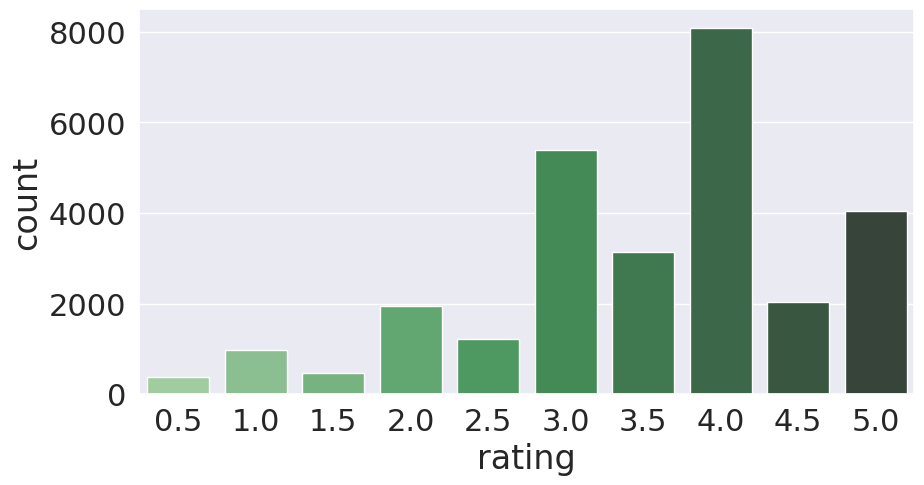

In [12]:
# counting of value of rating. It is seen rating = 4 is the most common rating. 
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = 'rating', data = data_sample, palette = 'Greens_d');

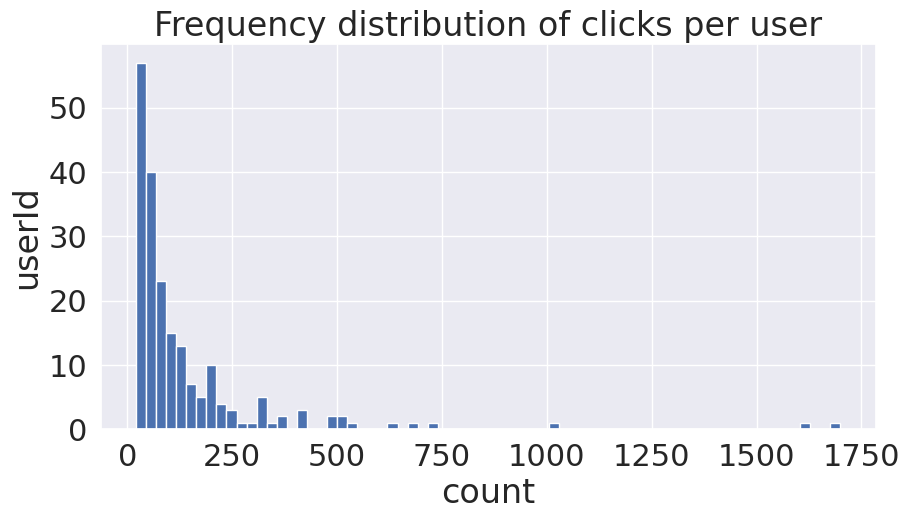

In [13]:
# Frequency distribution of clicks per user. It looks like only few users have more than 500 clicks while most users have clicks <30
data_sample['userId'].value_counts().hist(bins=70, figsize=(10, 5))
plt.title('Frequency distribution of clicks per user')
plt.ylabel('userId')
plt.xlabel('count')
plt.show()

### 4.1.2 Import meta data for product ID

Here we import meta data for items. We can equally import meta data for user. These meta data will be later used in modeling. The meta data will be crucial for the cold-start problem where we do not have enough historical clickstream data. 

In [14]:
product_name_sample = pd.read_csv('name_items.csv', 
                                 dtype={"productId":str, "title":str, "genre":str})
product_name_sample.shape

(9125, 3)

In [15]:
product_name_sample.head()

,productId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The features of data:
- productId: id of items
- title: name or title of items
- genres: genre of items

## 4.2 Data Preprocessing

### 4.2.1 Build Interaction Matrix 

Before fitting a recommendation model, we need to create an interaction matrix from transactional type interactions. This will be essential steps for most of recommendation type model like LightFM. 
Below, we build the intercation matrix passing the following parameters:
- norm: optional, True if a normalization of ratings is needed.
- threshold: value above which the rating is favorable. It is used if norm = True.
- nice_printing: If True (default) it prints some information.

In [16]:
interactions = build_interaction_matrix(data_sample, 
                                        "userId", 
                                        "productId", 
                                        "rating", 
                                         norm=True, 
                                         threshold= 3)
interactions.head()

Number of unique user in data: 201
Number of unique product Id in data: 5217


productId,1,10,100,100032,100034,100083,100159,100272,1003,100365,...,99149,99320,994,99468,996,99728,99764,99811,999,99917
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
101,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 4.2.2 Split data to train and test

Note that recommendation models such as LightLM works differently compared to other ML models as it expects the train and test sets to have the same dimension. Therefore the conventional train test split may not work. 
- In the below we create train and test data as pandas DataFrame and also sparse COO matrix. 
- Note that `create_train_test_data` method does not validate the interactions in the test set contain items and users that have historical interactions in the training set. Therefore this may result into a partial cold-start problem in the test set. We will later deal with this issue.  


In [17]:
train_pd, test_pd, train_interactions, test_interactions = create_train_test_data(interactions,
                                                                                  TEST_PERCENTAGE, 
                                                                                  nice_print = True)
train_pd.head()

Shape of train interaction data: (201, 5217)
Shape of test interaction data: (201, 5217)


productId,1,10,100,100032,100034,100083,100159,100272,1003,100365,...,99149,99320,994,99468,996,99728,99764,99811,999,99917
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
101,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 4.2.3 Build User and item dictionaries

In the following we create auxiliary dictionary which create a mapping between internal index of user and external use_id. This will be needed for recommendation models such as LightFM. 

In [18]:
users_dict_train= build_user_dict(train_pd) 
#showing the first 10 mapping
list(islice(users_dict_train.items(), 10))

[('1', 0),
 ('10', 1),
 ('100', 2),
 ('101', 3),
 ('102', 4),
 ('103', 5),
 ('104', 6),
 ('105', 7),
 ('106', 8),
 ('107', 9)]

In the following we create auxiliary dictionary to map item id to the name of item using meta data. 

In [19]:
items_dict= build_item_dict(product_name_sample, 'productId', 'title')
list(islice(items_dict.items(), 10))

[('1', 'Toy Story (1995)'),
 ('2', 'Jumanji (1995)'),
 ('3', 'Grumpier Old Men (1995)'),
 ('4', 'Waiting to Exhale (1995)'),
 ('5', 'Father of the Bride Part II (1995)'),
 ('6', 'Heat (1995)'),
 ('7', 'Sabrina (1995)'),
 ('8', 'Tom and Huck (1995)'),
 ('9', 'Sudden Death (1995)'),
 ('10', 'GoldenEye (1995)')]

## 4.3 Train Matrix Factorization model

Collaborative filtering is a method of making predictions about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person. 


Now we build a hybrid collaborative model using training data. Here are some important parameters that we can pass to this method:
- n_components:  the dimensionality of the feature latent embeddings.
- loss: loss function, one of (‘logistic’, ‘bpr’, ‘warp’, ‘warp-kos’).
- k: the k-th positive example will be selected from the n positive examples sampled for every user.
- epoch:  number of epochs to run
- n_jobs: Number of parallel computation threads to use.


Four loss functions are available:

- `logistic`: useful when both positive and negative interactions are present.
- `brp`: Bayesian Personalised Ranking. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- `wrap`: Weighted Approximate-Rank Pairwise. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- `warp-kos`: k-th order statistic. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [20]:
trained_model = fit_model(interactions= train_pd, 
                          n_components= 5, 
                          loss= 'bpr', 
                          k= 3, 
                          epoch= 30)

trained_model

## 4.4 Model Evaluation

The model_metrics API take trained_model build in previous step, and also train and test interaction matrices (created in the above) and produces a summary of metrics on train and test, and also plots the metric results as a function of epoch step. The main parameters of model_metric method includes:
- model: fitted LightFM model
- train_interactions: (scipy sparse COO matrix),  train interactions set
- test_interactions: (scipy sparse COO matrix), test interaction set
- k: number of recommendations, optional
- no_epochs: Number of epochs to run, optional
- nice_plot: if True, the metric results will be plotted.

<b> Note that the results below is just for illustration purpuse as we trained the model with small sample data.</b>  

,Evaluation Metric,Train,Test
0,Average AUC,0.91,0.76
1,Average Precision@4,0.44,0.07
2,Average recall@4,0.04,0.02


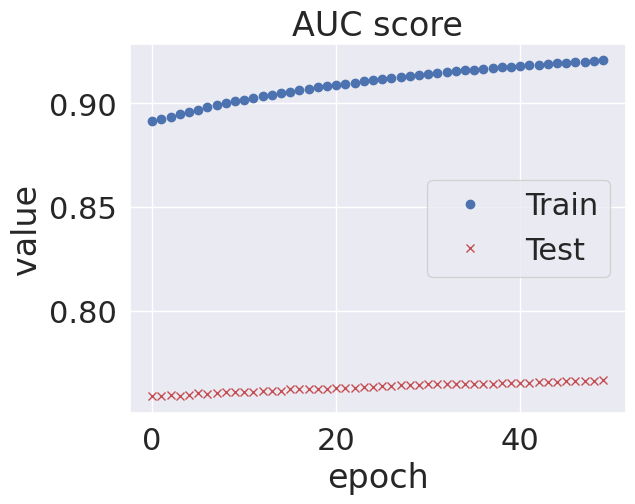

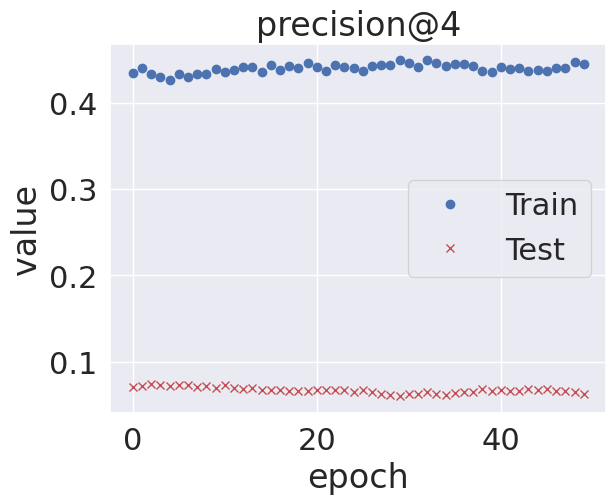

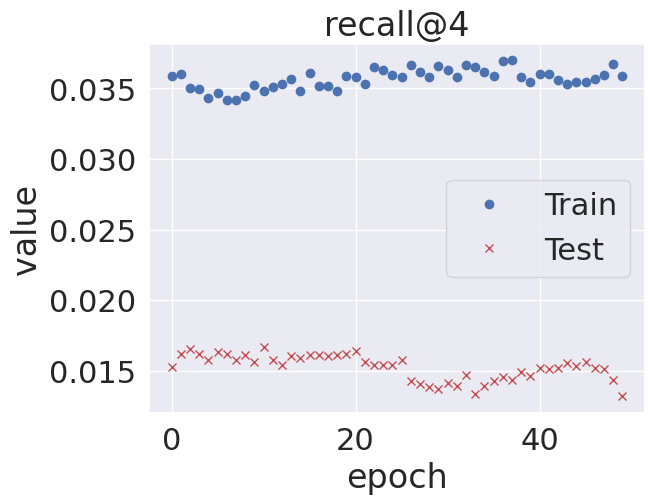

In [21]:
df_metric_results = model_metrics(trained_model, train_interactions, 
                   test_interactions, 
                   k=4,
                   no_epochs=50,
                   nice_plot=True)
df_metric_results

## 4.5 User recommendations 

Having trained the recommendation model, now we are ready to make some prediction. In the below, we show how to use `recommendations_for_user_items` method. This method provides top N recommendations for a user with user_id. The outcome will be a list of item_ids recommended for a user_id. 

The input parameters of this method are the following:
- model: Trained matrix factorization model.
- interactions: dataset used for training the model.
- user_id: user ID for which we need to generate recommendation (this id is an actual id from outset).
- user_dict: Dictionary containing interaction_index as key and integer mapped user_id as value. See the above. 
- item_dict: Dictionary containing item_id as key and item_name as value. See the above. 
- threshold: value above which the rating is favorable
- num_recommendations: Number of output recommendation request
- nice_print: if true the results will be printed out (this is for notebook usage).

In [22]:
# Given a user_id, recommend top num_recommendations items  
recommendations_for_user_items = recommendations_items_for_user(trained_model, 
                                                          train_pd,  
                                                          user_id = '1',
                                                          user_dict=users_dict_train, 
                                                          item_dict=items_dict,
                                                          threshold = 1,
                                                          num_recommendations = 4) 
recommendations_for_user_items

Known Likes:
1- Gods Must Be Crazy, The (1980)
2- Tron (1982)
3- Dracula (Bram Stoker's Dracula) (1992)
4- Cinema Paradiso (Nuovo cinema Paradiso) (1989)
5- Sleepers (1996)
6- Dumbo (1941)

 Recommended new items:
1- American Beauty (1999)
2- Terminator, The (1984)
3- Fight Club (1999)
4- Shining, The (1980)


['2858', '1240', '2959', '1258']

## 4.6 User-item recommendations

One of the common ask in the recommendation system is to recommend similar users who might be interested to a given item id. The `recommendations_users_for_item` method just does that. Recommend a list of top N (number_of_user) users for a given item. The parameters of this method are: 
- model:  Trained matrix factorization model.
- interactions:  dataset used for training the model.
- item_id: item ID for which we need to generate recommended users.
- number_of_user: Number of users needed as an output.

In [23]:
# Given an item_id, recommend top number_of_user for this item
recommendations_similar_users_for_item = recommendations_users_for_item(trained_model, 
                                                                        train_pd,
                                                                        item_id='31', 
                                                                        number_of_user= 4) 
recommendations_similar_users_for_item

['108', '145', '112', '144']

## 4.7 Item-item recommendations

In the below we show how to get recommendations similarto an item id. The model use similarity between 
the constructed embedding vectors of items. The first step is the build the embedding matrix of the training data.      

In [24]:
## Buid the embedding matrix from the trained model. 
Built_embedding_matrix = embedding_matrix(trained_model, train_pd)
Built_embedding_matrix.head()

productId,1,10,100,100032,100034,100083,100159,100272,1003,100365,...,99149,99320,994,99468,996,99728,99764,99811,999,99917
productId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.44,0.13,-0.17,0.71,0.90,-0.22,0.28,0.39,0.88,...,0.48,0.19,-0.10,-0.45,-0.66,-0.18,0.37,-0.28,0.50,0.08
10,0.44,1.00,0.50,0.15,-0.28,0.34,-0.24,-0.60,0.75,0.37,...,-0.52,-0.00,-0.54,-0.01,0.25,0.32,-0.60,-0.57,0.52,-0.23
100,0.13,0.50,1.00,-0.44,-0.15,-0.05,-0.52,-0.70,0.87,-0.03,...,-0.54,-0.86,0.33,-0.18,0.40,0.20,-0.62,0.18,0.25,-0.86
100032,-0.17,0.15,-0.44,1.00,-0.17,0.21,0.89,-0.22,-0.48,0.28,...,-0.06,0.60,-0.28,0.87,-0.13,-0.45,-0.24,-0.74,0.47,0.13
100034,0.71,-0.28,-0.15,-0.17,1.00,0.75,0.10,0.63,-0.15,0.71,...,0.89,0.12,0.45,-0.28,-0.91,-0.63,0.75,0.05,0.27,0.06


Having constructed the embedding matrix for all items, we can now get similair items to a given item id. 
Here are the parameters of the `recommendations_items_for_item` method:
- built_embedding_matrix: Pandas dataframe containing cosine distance matrix between items. Call embedding_matrix method in the above to build it.
- item_id: item id that we need to generate recommended items
- item_dict: Dictionary containing item_id as key and item_name as value
- n_items: Number of items needed for recommendation
- nice_print: if True, it prints the results. This is only useful for notebook.

In [25]:
# Recommend top n_items products similar to a given product id
recommendations_similar_items_for_item = recommendations_items_for_item(Built_embedding_matrix,
                                                                        item_id = '3',
                                                                        item_dict = items_dict,
                                                                        n_items = 4,
                                                                        nice_print= True)
                               
                               
recommendations_similar_items_for_item                                                     

Similar items to "Grumpier Old Men (1995)":
1- Barb Wire (1996)
2- Nymphomaniac: Volume II (2013)
3- Sudden Death (1995)
4- Executive Decision (1996)


['737', '108981', '9', '494']

# 5. Product recommendation with implicit Feedback

In implicit feedback use-cases, user preference are mainly captured by user clicked, watched movies, played songs, purchases or assigned tags, or taken actions.  In this case we have less signals and user does not provide any rating for items. 

## 5.1 Exploratory Data Analysis

In the case of implicit Feedback, there is no `rate` column. In this case, the use-item interaction contains historical clickstream data. A sample of such data shown below.  

In [26]:
data_sample_implicit_init = data_sample.copy()
data_sample_implicit_init.drop('rating', axis=1, inplace=True)
data_sample_implicit_init.head()

,userId,productId,timestamp
0,1,31,1260759144
1,1,1029,1260759179
2,1,1061,1260759182
3,1,1129,1260759185
4,1,1172,1260759205


In [27]:
# Dropping duplicated events
data_sample_implicit_init.drop_duplicates(ignore_index=True, inplace=True)
data_sample_implicit_init.shape

(27707, 3)

In some use-cases, only if users click more than certain numbers, then user intention should be taken into account. To account for this effect, we create a new feature called `Occur` which counts number of clicks or transactions over all history of data. This feature is in a sense similar to `rating` feature in the case of explicit feedback use-case (see the above).  

Note that the feature `Occur` is auxiliary and is not essential for the modeling. It can only be used if user want to impose some constrains on number of clicks that should be included in the model.  

In [28]:
# Create a column with name "Occur" which count number of click of a given product. 
data_sample_implicit = data_preprocessing_implicit_feedback(data_sample_implicit_init, 
                                     user_col= 'userId', 
                                     item_col= 'productId')
data_sample_implicit.head()

INFO:src.data_processing_utilities:timestamp feature exist in data, it will be dropped.


,userId,productId,Occur
0,1,31,15
1,1,1029,11
2,1,1061,13
3,1,1129,19
4,1,1172,11


In [29]:
# Calculate average number of click 
int(data_sample_implicit['Occur'].mean())

20

Below we should number of count for any value of `Occur`. It is seen that most cases we have small number of clicks or transactions. 

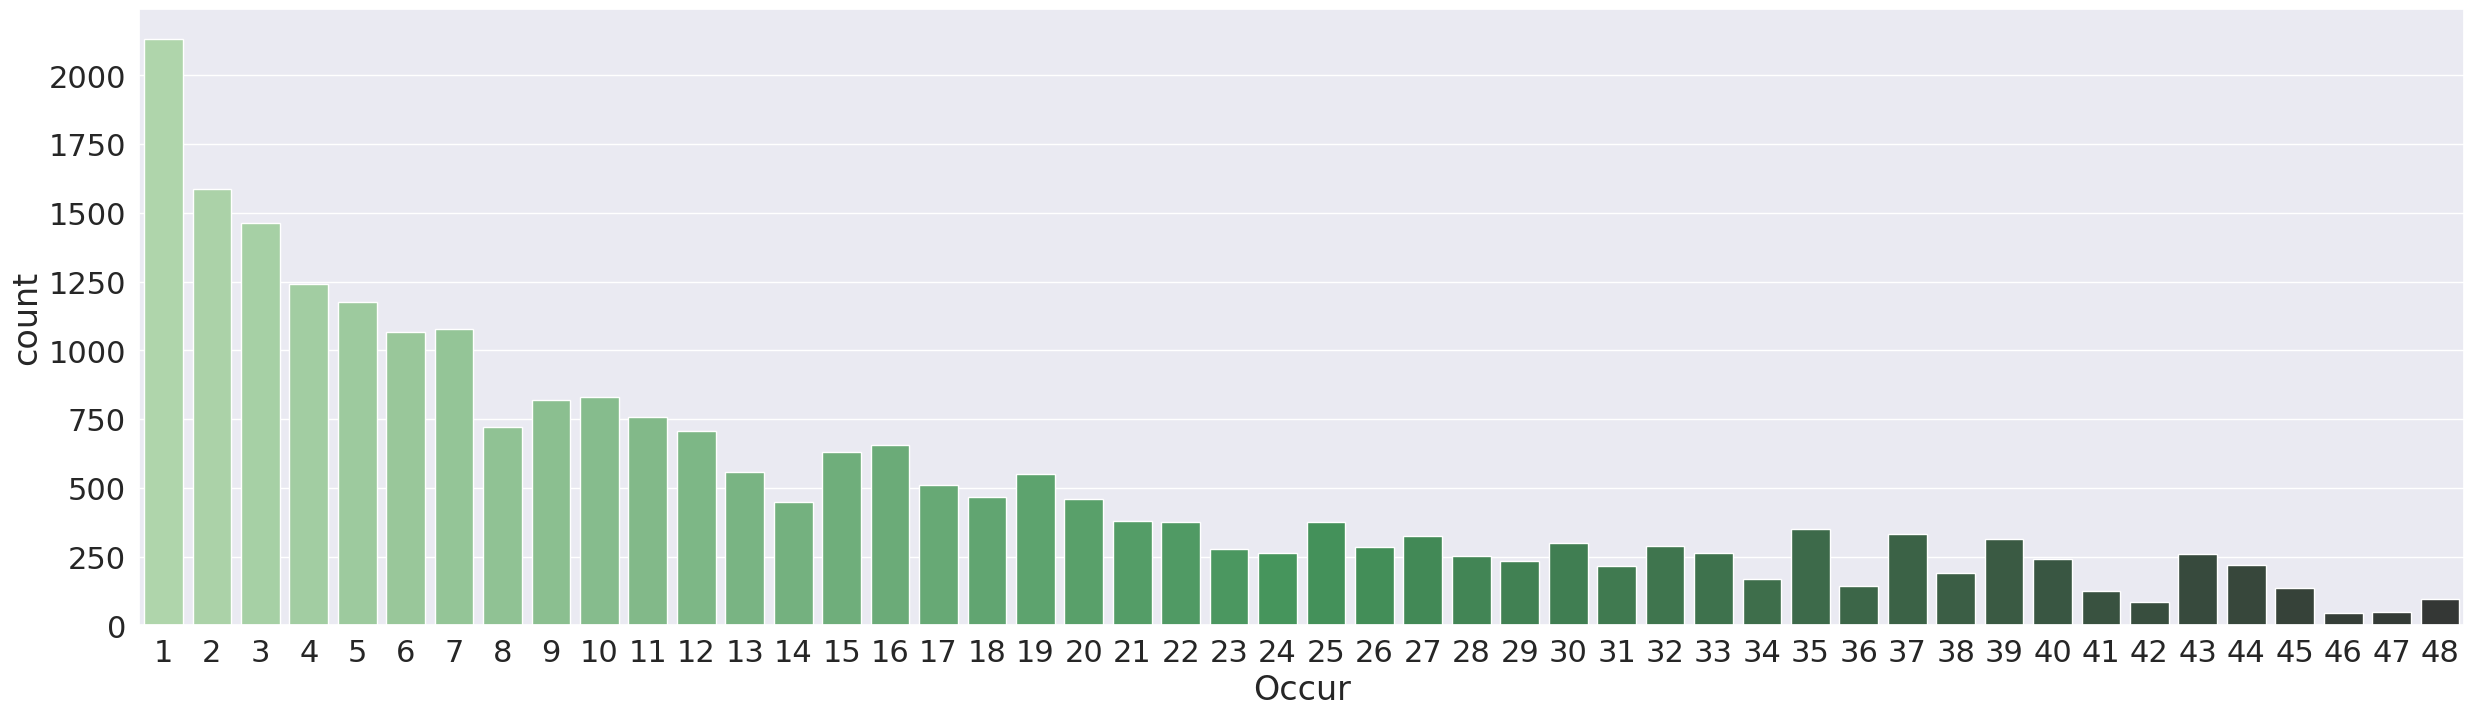

In [30]:
fig, ax = plt.subplots(figsize=(30, 8))
# Only showing Occur < 50. 
sns.countplot(x = 'Occur', data = data_sample_implicit[data_sample_implicit.Occur<50], palette = 'Greens_d');

The following steps for data preprocessing, traning model, model evaluation, and inference are all similar to the case of explicit feedback discussed in the above, with exactly the same API.  

## 5.2 Data Preprocessing

### 5.2.1 Build Interaction Matrix

Below we build the interaction matrix for implicit feedback data. Similar to the case of explicit feedback use-case, the parameters of `threshold` defines the value of `Occur` that is favorable. It is used if `norm = True`.
Note that in order to build interaction matrix we do not need to build `Occur` feature.  if the `threshold` is not known, then we should take `threshold=1`.  

In [31]:
threshold_mean =int(data_sample_implicit['Occur'].mean())
interactions_implicit = build_interaction_matrix(data_sample_implicit, 
                                        "userId", 
                                        "productId", 
                                        "Occur", 
                                         norm=True, 
                                         threshold= threshold_mean)
interactions_implicit.head()

Number of unique user in data: 201
Number of unique product Id in data: 5217


productId,1,10,100,100032,100034,100083,100159,100272,1003,100365,...,99149,99320,994,99468,996,99728,99764,99811,999,99917
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
101,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 5.2.2 Split data to train and test

In [32]:
train_pd, test_pd, train_interactions, test_interactions = create_train_test_data(interactions_implicit,
                                                                                  TEST_PERCENTAGE, 
                                                                                  nice_print = True)
train_pd.head()

Shape of train interaction data: (201, 5217)
Shape of test interaction data: (201, 5217)


productId,1,10,100,100032,100034,100083,100159,100272,1003,100365,...,99149,99320,994,99468,996,99728,99764,99811,999,99917
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
101,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 5.2.3 Build User and item dictionaries

In [33]:
users_dict_train= build_user_dict(train_pd) 
#showing the first 10 mapping
list(islice(users_dict_train.items(), 10))

[('1', 0),
 ('10', 1),
 ('100', 2),
 ('101', 3),
 ('102', 4),
 ('103', 5),
 ('104', 6),
 ('105', 7),
 ('106', 8),
 ('107', 9)]

## 5.3 Train Matrix Factorization model with implicit feedback data

In [34]:
trained_model = fit_model(interactions= train_pd, 
                          n_components= 10, 
                          loss= 'bpr', 
                          k= 10, 
                          epoch= 30)

trained_model

## 5.4 Model Evaluation

,Evaluation Metric,Train,Test
0,Average AUC,0.94,0.73
1,Average Precision@4,0.59,0.08
2,Average recall@4,0.10,0.04


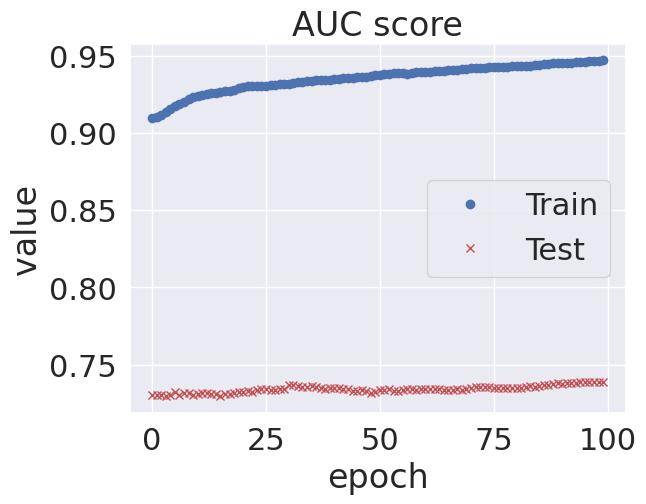

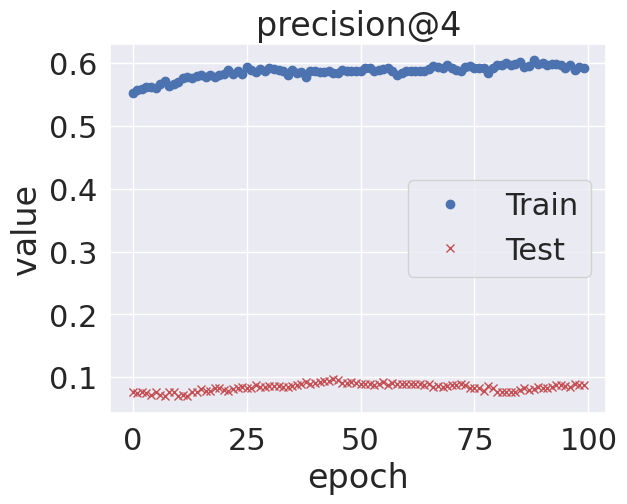

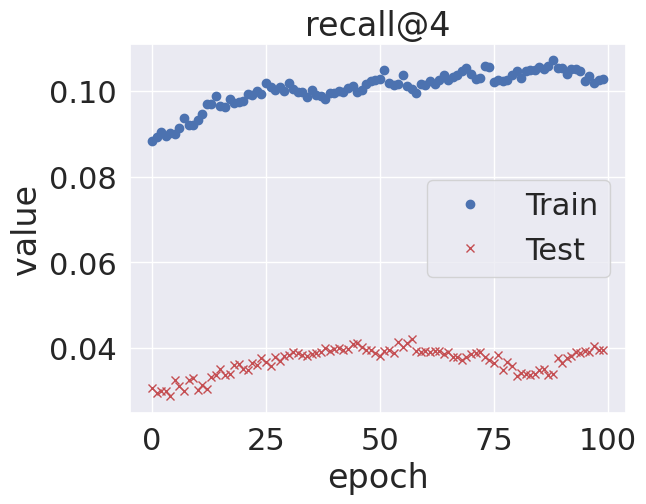

In [35]:
df_metric_results = model_metrics(trained_model, train_interactions, 
                   test_interactions, 
                   k=4,
                   no_epochs=100,
                   nice_plot=True)
df_metric_results

## 5.5 User recommendations

In [36]:
# Given a user id, recommend top 4 items  
recommendations_for_user_items = recommendations_items_for_user(trained_model, 
                                                          train_pd,  
                                                          user_id = '1',
                                                          user_dict=users_dict_train, 
                                                          item_dict=items_dict,
                                                          threshold = threshold_mean,
                                                          num_recommendations = 4) 
recommendations_for_user_items

Known Likes:

 Recommended new items:
1- Matrix, The (1999)
2- Pulp Fiction (1994)
3- Alien (1979)
4- Star Wars: Episode V - The Empire Strikes Back (1980)


['2571', '296', '1214', '1196']

## 5.6 User-item recommendations

In [37]:
recommendations_similar_users_for_item = recommendations_users_for_item(trained_model, 
                                                                        train_pd,
                                                                        item_id='31', 
                                                                        number_of_user= threshold_mean) 
recommendations_similar_users_for_item

['35',
 '76',
 '1',
 '158',
 '46',
 '113',
 '29',
 '135',
 '162',
 '170',
 '11',
 '71',
 '65',
 '45',
 '54',
 '123',
 '51',
 '52',
 '127',
 '114']

## 5.7 Item-item recommendations

In [36]:
Built_embedding_matrix = embedding_matrix(trained_model, train_pd)

In [38]:
recommendations_similar_items_for_item = recommendations_items_for_item(Built_embedding_matrix,
                                                                        item_id = '31',
                                                                        item_dict = items_dict,
                                                                        n_items = 10,
                                                                        nice_print= True)
                               
                               
recommendations_similar_items_for_item  

Similar items to "Dangerous Minds (1995)":
1- So Fine (1981)
2- Clone (Womb) (2010)
3- High School Musical 3: Senior Year (2008)
4- Frankenhooker (1990)
5- Richie Rich (1994)
6- Free Willy (1993)
7- Stargate (1994)
8- Awakenings (1990)
9- Paul Blart: Mall Cop (2009)
10- 5 Centimeters per Second (Byôsoku 5 senchimêtoru) (2007)


['5857',
 '91505',
 '62912',
 '26684',
 '374',
 '455',
 '316',
 '3105',
 '65802',
 '64993']

# 6. Conclusion

In this notebook we showed how to build a recommendation model. We illustrated the following steps: 
- Process the data, and build interaction matrix
- Train a collaborative filtering model
- Get item-user and user-user and item-item recommendation predictions

This notebook can be extended to incorporate user and item profile data in modeling. This extension is straightforward within the hybrid model we have used here. This notebook can also be extended to incorporate other recommendation models such as Neural Collaborative Filtering and Self-Attentive Sequential Recommendation models.  
- <b> Please reach out to the OCI Decision Team if you have any question about this notebook or you want to get access to advanced notebooks for recommendation which are based on Oracle innovation such 
Sequential Deep Matching Model with Features Support and Neural Network based Matrix Factorization Models. </b>
- <b> The OCI Decision team can help you to build a scalable recommendation system for your use-case.</b> 